In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from anndata import AnnData
import anndata
from statsmodels.stats.multitest import multipletests
import squidpy as sq
import warnings
warnings.filterwarnings('ignore')
from random import sample

result_dir = './recode/SpatialBench/'
data_dir = './data/SpatialBench/'

data_ids = os.listdir(result_dir)
softs = ['spanve-k','spanve-d','sepal','somde','moran','geary','r-gitto-sirank','r-sparkx','r-gitto-rank','spatialde'] #,'r-meringue'


index_cols = defaultdict(int)
index_cols.update({
    "r-gitto-rank":1,
    'r-gitto-sirank':1,
    'somde':3,
    'spatialde':3
})

p_use_columns = {
    "geary":"pval_norm_fdr_bh", 
    "moran":"pval_norm_fdr_bh", 
    "r-gitto-rank":"adj.p.value",
    "r-sparkx":"adjustedPval",
    'somde':'qval',
    'spatialde':'qval',
    'spanve-d':'fdrs',
    'spanve-k':'fdrs',
    'p.spanve-d':'fdrs',
    'p.spanve-k':'fdrs',
    'r-meringue':'p.adj'
}
score_use_columns = {
    'r-gitto-sirank':'scores',
    'sepal':'average',
}


def parse_file(data_dir,soft):
    path = os.path.join(result_dir,data_dir,soft)
    try:
        file = [i for i in os.listdir(path) if i.endswith('csv')][0]
    except:
        print(data_dir,soft,'have no result file.')
        return None
    file = os.path.join(path,file)
    if soft not in p_use_columns:
        use_col = score_use_columns[soft]
    elif soft in p_use_columns:
        use_col = p_use_columns[soft]
    else: print(soft)
        
    df = pd.read_csv(file,index_col=index_cols[soft])[use_col]
    df.index.name = 'genes'
    df = df.reset_index().groupby(by='genes').mean().iloc[:,0]
    df.name = soft
    return df


In [2]:
from sklearn.metrics.pairwise import paired_cosine_distances
recoder = pd.DataFrame(columns=['data','soft','s1','s2','nsig'])

for data_id in data_ids:
    
    df_datares = pd.concat(
        [parse_file(data_id,soft) for soft in softs],
        axis=1
    )
    dfmoranI = pd.read_csv(f'./recode/SpatialBench//{data_id}/moran/moranI.test.csv',index_col=0).iloc[:,0]
    dfgearyC = pd.read_csv(f'./recode/SpatialBench//{data_id}/geary/gearyC.test.csv',index_col=0).iloc[:,0]
    
    for ps in set(p_use_columns.keys())&set(df_datares.columns):
        df_datares[ps] = df_datares[ps].fillna(1)
    for ss in set(score_use_columns.keys())&set(df_datares.columns):
        df_datares[ps] = df_datares[ps].fillna(-1)
    
    for soft in df_datares.columns:

            if soft in p_use_columns:
                genes = df_datares.index[df_datares[soft]<0.05]
            elif soft in score_use_columns:
                n_select = max(10,int(0.5*df_datares.shape[0]))
                n_select = min(1000,n_select)
                
                thres = df_datares[soft].sort_values(ascending=False)[n_select]
                genes = df_datares.index[df_datares[soft]>thres]
                # genes = df_datares.index[df_datares[soft]>=sorted(df_datares[soft])[np.diff(sorted(df_datares[soft]),2).argmax()]]
            if len(genes)==0: 
                #genes = df_datares[soft].sort_values().index[0:int(0.05*df_datares.shape[0])]
                print(data_id,soft,'have no sig genes.')
                #continue
        
            recoder.loc[len(recoder),:] = data_id,soft,dfmoranI[genes].mean(),dfgearyC[genes].mean(),len(genes)

import seaborn as sns
import matplotlib.pyplot as plt

df_metrics = recoder
df_metrics['soft'] = df_metrics['soft'].map(
    {
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Gitto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Gitto-siRank*',
        'spatialde':'SpatialDE',
        'r-meringue':'MERINGUE',
        
    }
)

Dataset11.h5ad spanve-k have no sig genes.
Dataset11.h5ad spanve-d have no sig genes.
Dataset11.h5ad somde have no sig genes.
Dataset14.h5ad somde have no result file.
Dataset14.h5ad spatialde have no result file.
Dataset14.h5ad r-gitto-rank have no sig genes.
Dataset17.h5ad somde have no result file.
Dataset17.h5ad spatialde have no result file.
Dataset18.h5ad spanve-k have no sig genes.
Dataset18.h5ad spanve-d have no sig genes.
Dataset18.h5ad somde have no sig genes.
Dataset18.h5ad moran have no sig genes.
Dataset18.h5ad r-sparkx have no sig genes.
Dataset19.h5ad spanve-k have no sig genes.
Dataset19.h5ad spanve-d have no sig genes.
Dataset19.h5ad somde have no sig genes.
Dataset19.h5ad r-sparkx have no sig genes.
Dataset2.h5ad spanve-k have no sig genes.
Dataset2.h5ad spanve-d have no sig genes.
Dataset2.h5ad somde have no sig genes.
Dataset2.h5ad moran have no sig genes.
Dataset2.h5ad r-sparkx have no sig genes.
Dataset27.h5ad spanve-k have no sig genes.
Dataset27.h5ad spanve-d ha

In [3]:
df_metrics['data'] = df_metrics['data'].str.split('.').str[0]
df_metrics.columns = ['data_id','soft','moran\'s I','geary\'s C','n_svgenes']

Text(0.5, 0, 'Gene Number')

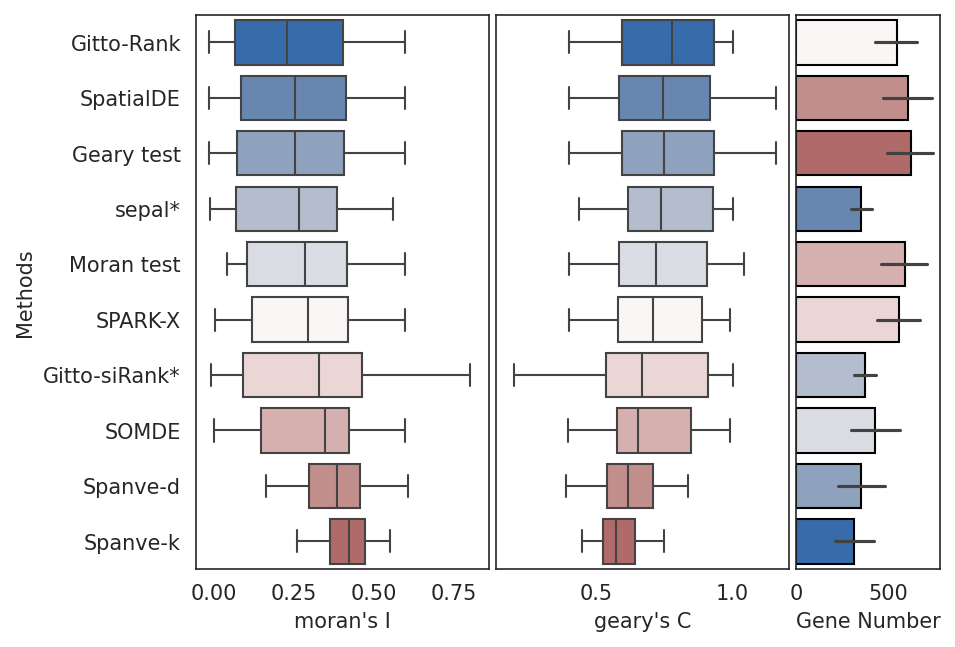

In [4]:
color_map = sns.color_palette('vlag',as_cmap=True)
saturation=0.75
order = df_metrics.groupby('soft')["moran's I"].apply(lambda x: x.mean()).sort_values().index

sns.set_style(style='white')
fig = plt.figure(dpi=150)
spec = fig.add_gridspec(1, 5)
axes = [
    fig.add_subplot(spec[0, 0:2]),
    fig.add_subplot(spec[0, 2:4]),
    fig.add_subplot(spec[0, -1])
]

fig.subplots_adjust(wspace=0.05)
# axes[0].get_shared_x_axes().join(axes[0],axes[1])

plot_metric = "moran's I"

sns.boxplot(
    # x='soft',y=plot_metric,
    orient='h',y='soft',x=plot_metric,
    data=df_metrics,
    order=order,
    ax =axes[0],linewidth=1,fliersize=0,saturation=saturation,
    palette={
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].apply(lambda x: x.mean()).sort_values().index)
    },
    whis=1
)
# axes[0].set_xticks([])
# axes[0].set_xlim(-0.1,0.7)
axes[0].set_xlabel('moran\'s I')
axes[0].set_ylabel('Methods')

plot_metric = "geary's C"
sns.boxplot(
    # x='soft',y=plot_metric,
    orient='h',y='soft',x=plot_metric,
    data=df_metrics,
    order=order,
    ax =axes[1], linewidth=1,fliersize=0,saturation=saturation,
    palette= {
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].apply(lambda x: x.mean()).sort_values(ascending=False).index)
    },
    whis=1
)
axes[1].set_yticks([])
# _ = axes[1].set_xticklabels([i.replace('r-','') for i in order], rotation=45) 
axes[1].set_ylabel('')
axes[1].set_xlabel('geary\'s C')
# axes[1].set_xlim(0.25,1.2)
# axes[1].set_xticks([0.5,0.75,1])

plot_metric = 'n_svgenes'
sns.barplot(
    data=df_metrics,#dfnsig.reset_index(),
    x=plot_metric,y='soft',orient='h',
    order=order,
    ax=axes[-1],
    palette= {
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].apply(lambda x: x.mean()).sort_values(ascending=True).index)
    },
    linewidth=1, edgecolor="0",errwidth=1.5
)
axes[-1].set_yticks([])
axes[-1].set_ylabel('')
axes[-1].set_xlabel('Gene Number')

In [5]:
fig.savefig('./Results/SpatialMetrics_SPB.pdf',bbox_inches='tight')
df_metrics.to_csv('./Results/SPB_metrics.csv',index=False)

## Statistical test

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
result = pd.read_csv('./Results/SPB_metrics.csv')
result

,data_id,soft,moran's I,geary's C,n_svgenes
0,Dataset10,Spanve-k,0.432323,0.570967,6
1,Dataset10,Spanve-d,0.335212,0.669750,11
2,Dataset10,sepal*,0.064401,0.940658,489
3,Dataset10,SOMDE,0.373390,0.631609,8
4,Dataset10,Moran test,0.066893,0.937858,605
...,...,...,...,...,...
426,Dataset8,sepal*,0.073860,0.925917,125
427,Dataset8,Moran test,0.125130,0.875083,228
428,Dataset8,Geary test,0.124024,0.876142,230
429,Dataset8,SPARK-X,0.137511,0.862630,202


In [3]:
# test for Spanve-k and other methods
# use wilcoxon rank sum test
softs = result['soft'].unique()
testres = pd.DataFrame(columns = softs,index=softs)
for soft1 in softs:
    for soft2 in softs:
        if soft1==soft2: continue
        testres.loc[soft1,soft2] = stats.ranksums(
            result[result['soft']==soft1]['moran\'s I'].values,
            result[result['soft']==soft2]['moran\'s I'].values,
            nan_policy='omit',
            alternative='greater'
        ).pvalue

In [25]:
testres

,Spanve-k,Spanve-d,sepal*,SOMDE,Moran test,Geary test,Gitto-siRank*,SPARK-X,Gitto-Rank,SpatialDE
Spanve-k,NaN,0.079292,0.000079,0.005796,0.000236,0.000066,0.009788,0.000341,0.000023,0.000153
Spanve-d,0.920708,NaN,0.002252,0.073511,0.005031,0.00153,0.069543,0.007802,0.000691,0.003153
sepal*,0.999921,0.997748,NaN,0.905759,0.710234,0.420628,0.809463,0.739569,0.341299,0.439713
SOMDE,0.994204,0.926489,0.094241,NaN,0.210116,0.08326,0.408609,0.233246,0.056669,0.107603
Moran test,0.999764,0.994969,0.289766,0.789884,NaN,0.199252,0.658761,0.564463,0.167768,0.264212
Geary test,0.999934,0.99847,0.579372,0.91674,0.800748,NaN,0.857133,0.820965,0.448539,0.509455
Gitto-siRank*,0.990212,0.930457,0.190537,0.591391,0.341239,0.142867,NaN,0.36267,0.119595,0.170828
SPARK-X,0.999659,0.992198,0.260431,0.766754,0.435537,0.179035,0.63733,NaN,0.147648,0.241821
Gitto-Rank,0.999977,0.999309,0.658701,0.943331,0.832232,0.551461,0.880405,0.852352,NaN,0.575197
SpatialDE,0.999847,0.996847,0.560287,0.892397,0.735788,0.490545,0.829172,0.758179,0.424803,NaN


<Axes: >

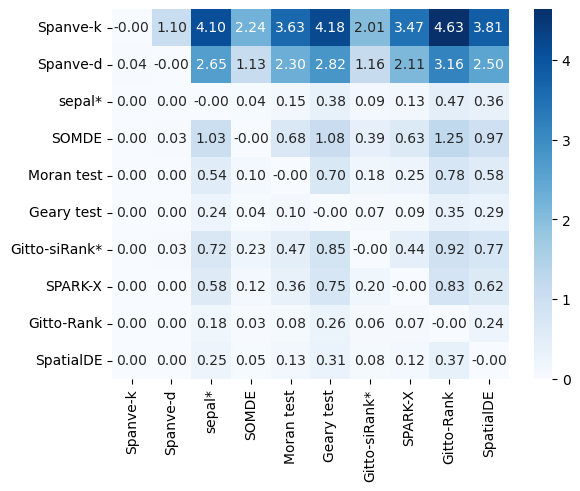

In [24]:
sns.heatmap(-np.log10(testres.fillna(1)),cmap='Blues',annot=True,fmt='.2f')

In [6]:
x = result[result['soft']=='Spanve-k']['moran\'s I'].values
np.nanmean(x),np.nanstd(x)

(0.41437697217347064, 0.13123141868311924)

In [7]:
x = result[result['soft']=='Spanve-k']['geary\'s C'].values
np.nanmean(x),np.nanstd(x)

(0.5853438788416759, 0.13147804512261743)

In [20]:
x = result[result['soft']=='Spanve-k']['n_svgenes'].values
# ci values
ci = stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x))
np.nanmean(x),ci

(313.84444444444443, (197.76804552914876, 429.9208433597401))